### Exercise 6.2

In [6]:
import random

class RandomWalk:
    def __init__(self, n_states):
        self.n_states = n_states
        self.terminal_state = -1
        self.initial_state = n_states // 2

    def step(self, state):
        if state < 0 or state >= self.n_states:
            raise ValueError("State out of bounds")
        
        if state == self.n_states - 1:
            next_state = random.choice([state - 1, self.terminal_state])
            if next_state == self.terminal_state:
                return next_state, 1.0
            else:
                return next_state, 0.0
            
        
        return random.choice([state - 1, state + 1]), 0.0
    
    def is_terminal(self, state):
        return state == self.terminal_state
    
    def true_values(self):
        return [(i+1) / (self.n_states + 1) for i in range(self.n_states)]


In [7]:
from tqdm import tqdm
import numpy as np

def n_step_TD_prediction(env, n, alpha=0.1, gamma=1, num_episodes=1000, use_td_error=False, progress_bar=True):
    V = [0.5] * env.n_states + [0.0]
    V = np.array(V)
    history = []

    if progress_bar:
        episodes_range = tqdm(range(num_episodes))
    else:
        episodes_range = range(num_episodes)

    for episode in episodes_range:
        state = env.initial_state

        T = float("inf")
        t = -1
        states = [state]
        rewards = [0.0]

        dV = np.zeros_like(V)

        while True:
            t += 1
            if t < T:
                state = states[t]
                next_state, reward = env.step(state)
                states.append(next_state)
                rewards.append(reward)

                if env.is_terminal(next_state):
                    T = t + 1


            t_update = t - n + 1

            if t_update >= 0:
                G = sum(
                    gamma ** (i - t_update - 1) * rewards[i]
                    for i in range(t_update + 1, min(t_update + n, T) + 1)
                )

                if t_update + n < T:
                    G += gamma**n * V[states[t_update + n]]
                
                if use_td_error:
                    dV[states[t_update]] += alpha * (G - V[states[t_update]])
                else:
                    V[states[t_update]] += alpha * (G - V[states[t_update]])


            if t_update == T - 1:
                V += dV
                break


        history.append(V.copy()[:-1])
        
    return V[:-1], history

In [241]:
env = RandomWalk(21)
true_values = env.true_values()
n = 5
alpha = 0.1
num_episodes = 100
gamma = 1

In [246]:
print("True Values:", true_values)

# Using normal update
V_normal, history_normal = n_step_TD_prediction(env, n, alpha, gamma, num_episodes, progress_bar=False)
print("Estimated Values:", V_normal)


# # Using TD error
V_td_error, history_td_error = n_step_TD_prediction(env, n, alpha, gamma, num_episodes, use_td_error=True, progress_bar=False)
print("Estimated Values with TD Error:", V_td_error)

print("Normal update mean square error:  ", np.mean((V_normal - true_values)**2))
print("TD error update mean square error:", np.mean((V_td_error - true_values)**2))

True Values: [0.045454545454545456, 0.09090909090909091, 0.13636363636363635, 0.18181818181818182, 0.22727272727272727, 0.2727272727272727, 0.3181818181818182, 0.36363636363636365, 0.4090909090909091, 0.45454545454545453, 0.5, 0.5454545454545454, 0.5909090909090909, 0.6363636363636364, 0.6818181818181818, 0.7272727272727273, 0.7727272727272727, 0.8181818181818182, 0.8636363636363636, 0.9090909090909091, 0.9545454545454546]
Estimated Values: [0.02711247 0.0430336  0.08000851 0.11398688 0.14500722 0.20688155
 0.23257286 0.2537947  0.33340372 0.41570699 0.48216426 0.52119014
 0.53683719 0.66851387 0.7190332  0.77339109 0.8692301  0.92858123
 0.943492   0.95519109 0.98698769]
Estimated Values with TD Error: [0.02596247 0.10117428 0.15890205 0.17580826 0.21507394 0.35685931
 0.54156199 0.49859431 0.57660421 0.46531137 0.67343921 0.60215019
 0.63414251 0.76303057 0.72024857 0.78577441 0.89580549 0.9387305
 0.92666912 0.92813586 0.94535371]
Normal update mean square error:   0.004170068195140

In [263]:
env = RandomWalk(21)
true_values = env.true_values()
n = 5
alpha = 0.1
num_episodes = 25
gamma = 1

V_normal = []
history_normal = []

V_td_error = []
history_td_error = []


for i in range(100):
    V, history = n_step_TD_prediction(env, n, alpha, gamma, num_episodes, progress_bar=False)
    V_normal.append(V)
    history_normal.append(history)

    V, history = n_step_TD_prediction(env, n, alpha, gamma, num_episodes, use_td_error=True, progress_bar=False)
    V_td_error.append(V)
    history_td_error.append(history)

V_normal = np.array(V_normal)
history_normal = np.array(history_normal)

V_td_error = np.array(V_td_error)
history_td_error = np.array(history_td_error)

V_normal_MSE = np.mean((V_normal - true_values)**2)
V_td_error_MSE = np.mean((V_td_error - true_values)**2)


# Larger number of episodes breaks the estimation for TD error update
print("Normal update mean square error:  ", V_normal_MSE)
print("TD error update mean square error:", V_td_error_MSE)

Normal update mean square error:   0.004444461003097974
TD error update mean square error: 74.35386049637461


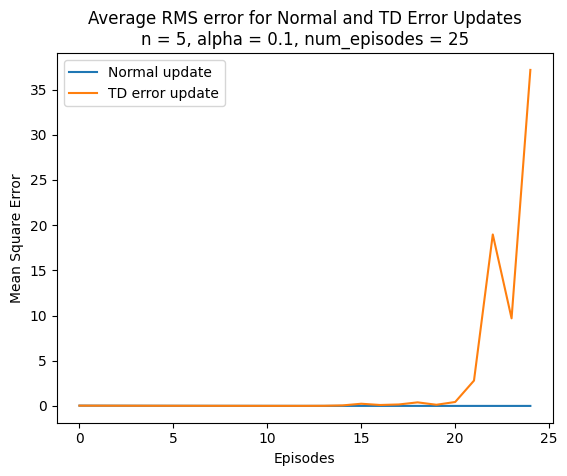

In [282]:
import matplotlib.pyplot as plt

normal_update_error_history = (((history_normal - true_values) ** 2).mean(axis=-1)**1/2).mean(axis=0)
td_update_error_history = (((history_td_error - true_values) ** 2).mean(axis=-1)**1/2).mean(axis=0)
# print(normal_update_error_history)
# print(td_update_error_history)

plt.plot(normal_update_error_history, label="Normal update")
plt.plot(td_update_error_history, label="TD error update")
plt.xlabel("Episodes")
plt.ylabel("Mean Square Error")
plt.legend()
plt.title(f"Average RMS error for Normal and TD Error Updates\n"
          f"n = {n}, alpha = {alpha}, num_episodes = {num_episodes}")
plt.show()